In [31]:
import os
import re
import numpy as np
import pandas as pd
import dask.array as da
import matplotlib.pyplot as plt
import tifffile
from aicsimageio import AICSImage
from cellpose import models
import napari

In [2]:
# relabel labels to be numbered consecutively
def relabel(mask):
    uniques = np.unique(mask)
    for new, old in enumerate(uniques):
        mask[mask==old] = new
    return mask

## IO

In [3]:
# Enter the path to the .lif file to be processed
fn = r'Z:\zmbstaff\9309\Raw_Data\240503_dataset_SPY-DNA-titration\Transduced cell line with dyes stimulated 20x.lif'

In [4]:
# load .lif for inspection:
lif_img = AICSImage(fn, reconstruct_mosaic=False)

In [5]:
scenes = lif_img.scenes
scenes

('Stimulated 20x/B/2/R1',
 'Stimulated 20x/B/2/R1/FLIM/Intensity',
 'Stimulated 20x/B/2/R1/FLIM/Fast Flim',
 'Stimulated 20x/B/2/R1/FLIM/Standard Deviation',
 'Stimulated 20x/B/2/R1/FLIM/Pattern Matching Scatter Plot Channel 1',
 'Stimulated 20x/B/2/R2',
 'Stimulated 20x/B/2/R2/FLIM/Intensity',
 'Stimulated 20x/B/2/R2/FLIM/Fast Flim',
 'Stimulated 20x/B/2/R2/FLIM/Standard Deviation',
 'Stimulated 20x/B/2/R2/FLIM/Pattern Matching Scatter Plot Channel 1',
 'Stimulated 20x/B/2/R3',
 'Stimulated 20x/B/2/R3/FLIM/Intensity',
 'Stimulated 20x/B/2/R3/FLIM/Fast Flim',
 'Stimulated 20x/B/2/R3/FLIM/Standard Deviation',
 'Stimulated 20x/B/2/R3/FLIM/Pattern Matching Scatter Plot Channel 1',
 'Stimulated 20x/B/2/R4',
 'Stimulated 20x/B/2/R4/FLIM/Intensity',
 'Stimulated 20x/B/2/R4/FLIM/Fast Flim',
 'Stimulated 20x/B/2/R4/FLIM/Standard Deviation',
 'Stimulated 20x/B/2/R4/FLIM/Pattern Matching Scatter Plot Channel 1',
 'Stimulated 20x/B/2/R5',
 'Stimulated 20x/B/2/R5/FLIM/Intensity',
 'Stimulated 20x/

In [6]:
def parse_scenes(scenes: list[str]) -> pd.DataFrame:
    # Iterate through data and extract information
    items = []
    for i, item in enumerate(scenes):
        if 'FLIM' not in item:
            items.append([i, item])
    return items

In [7]:
items = parse_scenes(scenes)
items

[[0, 'Stimulated 20x/B/2/R1'],
 [5, 'Stimulated 20x/B/2/R2'],
 [10, 'Stimulated 20x/B/2/R3'],
 [15, 'Stimulated 20x/B/2/R4'],
 [20, 'Stimulated 20x/B/2/R5'],
 [25, 'Stimulated 20x/B/3/R1'],
 [30, 'Stimulated 20x/B/3/R2'],
 [35, 'Stimulated 20x/B/3/R3'],
 [40, 'Stimulated 20x/B/3/R4'],
 [45, 'Stimulated 20x/B/3/R5'],
 [50, 'Stimulated 20x/B/4/R1'],
 [55, 'Stimulated 20x/B/4/R2'],
 [60, 'Stimulated 20x/B/4/R3'],
 [65, 'Stimulated 20x/B/4/R4'],
 [70, 'Stimulated 20x/B/4/R5'],
 [75, 'Stimulated 20x/B/5/R1'],
 [80, 'Stimulated 20x/B/5/R2'],
 [85, 'Stimulated 20x/B/5/R3'],
 [90, 'Stimulated 20x/B/5/R4'],
 [95, 'Stimulated 20x/B/5/R5'],
 [100, 'Stimulated 20x/B/6/R1'],
 [105, 'Stimulated 20x/B/6/R2'],
 [110, 'Stimulated 20x/B/6/R3'],
 [115, 'Stimulated 20x/B/6/R4'],
 [120, 'Stimulated 20x/B/6/R5']]

In [8]:
scene_data = []
for i, row in items:
    lif_img.set_scene(i)
    scene_data.append(lif_img.dask_data)
scene_data = da.stack(scene_data)
scene_data = scene_data[:,0,:,0]

The Axes are:
- 0: image no.
- 1: channel
- 2: y
- 3: x

In [9]:
scene_data

dask.array<getitem, shape=(25, 5, 512, 512), dtype=uint16, chunksize=(1, 1, 512, 512), chunktype=numpy.ndarray>

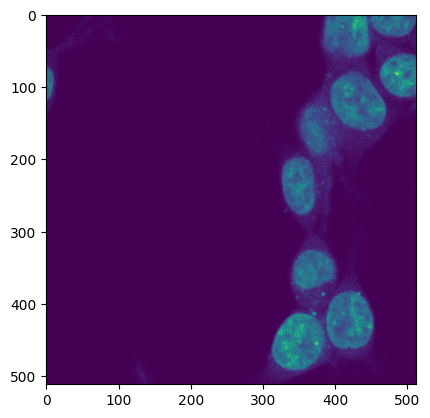

In [10]:
plt.imshow(scene_data[0,2].compute())

In [11]:
data = da.stack([scene_data[:,2], scene_data[:,0]+scene_data[:,1]], axis=1).astype(float)

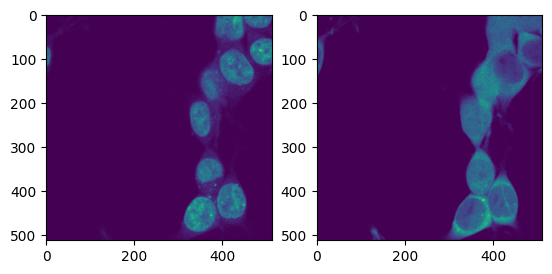

In [12]:
fig, axs = plt.subplots(1,2)
axs[0].imshow(data[0,0])
axs[1].imshow(data[0,1])

## cellpose

In [13]:
%%time
data_cp = [im for im in data.compute()]

CPU times: total: 33.6 s
Wall time: 32.2 s


### nuclei

In [14]:
%%time
model_nucleus = models.Cellpose(gpu=True, model_type='nuclei')
masks_nucleus, *_ = model_nucleus.eval(
    data_cp,
    diameter=60,
    channels=[1,0],
    flow_threshold=0.4,
    cellprob_threshold=0.0,
    do_3D=False,
    normalize=True,
)
masks_nucleus = np.stack(masks_nucleus)

CPU times: total: 17 s
Wall time: 17 s


### cells

In [15]:
%%time
model_cell = models.Cellpose(gpu=True, model_type='cyto2')
masks_cell, *_ = model_cell.eval(
    data_cp,
    diameter=80,
    channels=[2,1],
    flow_threshold=0.4,
    cellprob_threshold=0.0,
    do_3D=False,
    normalize=True,
)
masks_cell = np.stack(masks_cell)

CPU times: total: 12.8 s
Wall time: 12.2 s


In [30]:
viewer = napari.Viewer()
viewer.add_image(scene_data, channel_axis = 1)
viewer.add_labels(masks_nucleus)
viewer.add_labels(masks_cell)

<Labels layer 'masks_cell' at 0x1fd84a6c9d0>

# Filtering

### Remove nuclei from cell-masks

In [16]:
masks_cyto = []
for i, (mask_cell, mask_nucleus) in enumerate(zip(masks_cell, masks_nucleus)):
    mask_cyto = mask_cell.copy()
    mask_cyto[mask_nucleus!=0] = 0
    masks_cyto.append(mask_cyto)

### Filter for nucleus / cytoplasm size

In [17]:
sizes_nuc_all = []
sizes_cyt_all = []
for i, (mask_cell, mask_cyto) in enumerate(zip(masks_cell, masks_cyto)):
    sizes_nuc = []
    sizes_cyt = []
    for n in range(1, mask_cell.max()+1):
        sizes_nuc.append(np.count_nonzero(mask_cell==n) - np.count_nonzero(mask_cyto==n))
        sizes_cyt.append(np.count_nonzero(mask_cyto==n))
    sizes_nuc_all.append(sizes_nuc)
    sizes_cyt_all.append(sizes_cyt)

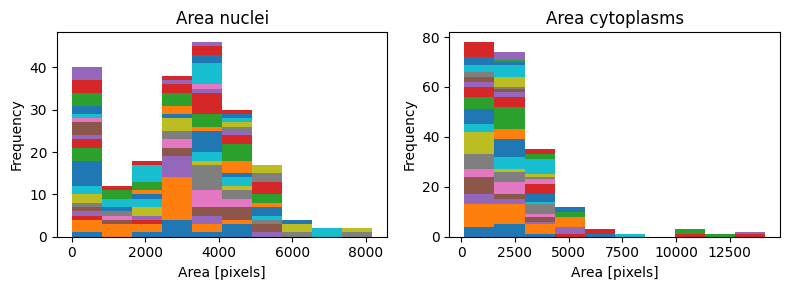

In [18]:
fig, axs = plt.subplots(1,2, figsize=(8,3))

axs[0].set_title('Area nuclei')
axs[0].hist(sizes_nuc_all, histtype='bar', stacked=True)
axs[0].set_xlabel('Area [pixels]')
axs[0].set_ylabel('Frequency')

axs[1].set_title('Area cytoplasms')
axs[1].hist(sizes_cyt_all, histtype='bar', stacked=True)#, label=[f"file {i}" for i in range(len(fns))])
#axs[1].legend(prop={'size': 10})
axs[1].set_xlabel('Area [pixels]')
axs[1].set_ylabel('Frequency')

plt.tight_layout()

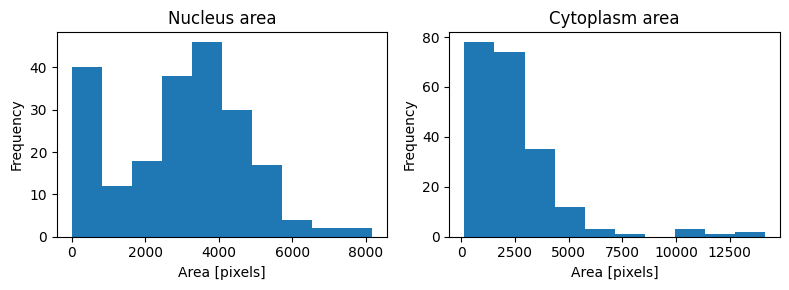

In [19]:
fig, axs = plt.subplots(1,2, figsize=(8,3))

axs[0].set_title('Nucleus area')
axs[0].hist(np.concatenate(sizes_nuc_all), histtype='bar')
axs[0].set_xlabel('Area [pixels]')
axs[0].set_ylabel('Frequency')

axs[1].set_title('Cytoplasm area')
axs[1].hist(np.concatenate(sizes_cyt_all), histtype='bar')
axs[1].set_xlabel('Area [pixels]')
axs[1].set_ylabel('Frequency')

plt.tight_layout()

In [20]:
# define cutoffs for nucleus and cytoplasm areas
min_area_nuc = 1000
min_area_cyto = 1000

In [21]:
masks_cyto_filt = []
for i, (mask_cyto, sizes_nuc, sizes_cyt) in enumerate(zip(masks_cyto, sizes_nuc_all, sizes_cyt_all)):
    mask_cyto_filt = mask_cyto.copy()
    for n, (size_nuc, size_cyt) in enumerate(zip(sizes_nuc, sizes_cyt)):
        if size_nuc<min_area_nuc or size_cyt<min_area_cyto:
            mask_cyto_filt[mask_cyto==n+1] = 0
    masks_cyto_filt.append(mask_cyto_filt)
masks_cyto_filt = [relabel(mask_cyto_filt) for mask_cyto_filt in masks_cyto_filt]

### Summary

In [38]:
viewer = napari.Viewer()
viewer.add_image(np.stack([img[[0,1,2,3]] for img in scene_data]), channel_axis=1, name=['donor','acceptor','nucleus','actin'])
viewer.add_labels(masks_nucleus)
viewer.add_labels(np.stack(masks_cell), name='masks_cyto', visible=False)
viewer.add_labels(np.stack(masks_cyto_filt), name='masks_cyto_filt')

<Labels layer 'masks_cyto_filt' at 0x1fd9352e890>

# Export

In [22]:
# define export directory:
export_dir = r'Z:\zmbstaff\9309\Raw_Data\240503_dataset_SPY-DNA-titration\exported_masks'
os.makedirs(export_dir, exist_ok=True)

In [26]:
[item[1] for item in items]

['Stimulated 20x/B/2/R1',
 'Stimulated 20x/B/2/R2',
 'Stimulated 20x/B/2/R3',
 'Stimulated 20x/B/2/R4',
 'Stimulated 20x/B/2/R5',
 'Stimulated 20x/B/3/R1',
 'Stimulated 20x/B/3/R2',
 'Stimulated 20x/B/3/R3',
 'Stimulated 20x/B/3/R4',
 'Stimulated 20x/B/3/R5',
 'Stimulated 20x/B/4/R1',
 'Stimulated 20x/B/4/R2',
 'Stimulated 20x/B/4/R3',
 'Stimulated 20x/B/4/R4',
 'Stimulated 20x/B/4/R5',
 'Stimulated 20x/B/5/R1',
 'Stimulated 20x/B/5/R2',
 'Stimulated 20x/B/5/R3',
 'Stimulated 20x/B/5/R4',
 'Stimulated 20x/B/5/R5',
 'Stimulated 20x/B/6/R1',
 'Stimulated 20x/B/6/R2',
 'Stimulated 20x/B/6/R3',
 'Stimulated 20x/B/6/R4',
 'Stimulated 20x/B/6/R5']

In [32]:
for fn, mask in zip([item[1] for item in items], masks_cyto_filt):
    export_name = os.path.join(export_dir, fn.replace('/','_')+"_mask.tif")
    tifffile.imwrite(export_name, mask, photometric='minisblack')